# Summary

Run ELASPIC on a set of CORE or INTERFACE PDBs.

----

# Imports

In [1]:
%run imports.ipynb

2016-09-07 12:02:47.315441


In [2]:
%run db.ipynb

MySQL database already running...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-09-07 12:02:47.459530


In [3]:
NOTEBOOK_NAME = 'elaspic_standalone'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

In [4]:
# Start a database connection
db_local = datapkg.MySQLConnection(
    connection_string=db_daemon.get_connection_string(NOTEBOOK_NAME),
    shared_folder=os.environ['DB_TEMPDIR'],
    storage_host=None,
    datadir=db_daemon.datadir,
    echo=False,
    db_engine='MyISAM',
)

In [5]:
PDB_DIR = '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb'
# BLAST_DB_DIR = '/home/kimlab1/database_data/blast/db'
BLAST_DB_DIR = '/home/strokach/databases/blast/db'
ARCHIVE_DIR = '/home/kimlab1/database_data/elaspic_v2'

# Load data

In [6]:
CORE_DATASETS = [
    'protherm', 'protherm_star',
]
    
INTERFACE_DATASETS = [
    # No partner uniprot provided:
    'ab_bind', 'benedix_et_al', 'hiv_escape_mutations',
    #
    'kortemme_baker', 'skempi',
]

assert not (set(CORE_DATASETS) & set(INTERFACE_DATASETS))

In [7]:
DATA = {}

for dataset in CORE_DATASETS:
    DATA[dataset] = pd.read_sql_table(dataset, db.engine, schema='protein_folding_energy')

for dataset in INTERFACE_DATASETS:
    DATA[dataset] = pd.read_sql_table(dataset, db.engine, schema='protein_interaction_energy')

In [8]:
display(DATA['protherm'].head())
print(DATA['protherm'].shape[0])

,idx,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,ddg_exp_pstar
0,1,1a23,A,A_C30S,P0AEG4,C49S,PF01323,1.80,NaN
1,2,1a23,A,A_C30S.A_C33S,P0AEG4,C49S.C52S,PF01323,2.00,NaN
2,3,1a23,A,A_C33S,P0AEG4,C52S,PF01323,1.10,NaN
3,4,1a23,A,A_H32L,P0AEG4,H51L,PF01323,-4.95,NaN
4,5,1a23,A,A_H32S,P0AEG4,H51S,PF01323,-4.40,NaN


4467


# RUN

In [9]:
DATASET = 'protherm_star'
SUFFIX = '_2'

JOB_NAME = DATASET + SUFFIX

In [10]:
print(DATASET)
print(SUFFIX)
print(JOB_NAME)

protherm_star
_2
protherm_star_2


In [11]:
DF = DATA[DATASET].copy()
print(DF.shape[0])

3636


In [12]:
# Remove multi-mutants (for now)
_before = DF.shape[0]
DF = DF[DF['pdb_mutation'].notnull()]
DF = DF[~DF['pdb_mutation'].str.contains('\.')]
DF = DF[~DF['pdb_mutation'].str.contains(',')]
print("Lost {} multi-mutant rows.".format(_before - DF.shape[0]))

Lost 24 multi-mutant rows.


In [13]:
if not DF['pdb_mutation'].str.contains('_').all():
    print("Adding 'pdb_chain' to 'pdb_mutation'")
    DF['pdb_mutation'] = DF['pdb_chain'] + '_' + DF['pdb_mutation']

In [14]:
if 'partner_pdb_chain' not in DF.columns:
    DF['partner_pdb_chain'] = np.nan
    
if 'partner_uniprot_id' not in DF.columns:
    DF['partner_uniprot_id'] = np.nan


In [15]:
print(DF.shape[0])

3612


In [16]:
DF['pdb_file'] = PDB_DIR + ('/pdb' + DF['pdb_id'] + '.ent.gz')

In [17]:
DF.shape

(3612, 10)

In [18]:
RUN_STAGE = 2  # 1: Provean and homology models, 2: Mutations
print("Run stage: {}".format(RUN_STAGE))

try:
    del DF_TO_CALCULATE, SYSTEM_COMMAND_TEMPLATE
except NameError:
    pass

Run stage: 2


In [19]:
if RUN_STAGE == 1:
    DF_TO_CALCULATE = DF.drop_duplicates('pdb_file')
    print("Analysing {} unique proteins...".format(len(DF_TO_CALCULATE)))

    SYSTEM_COMMAND_TEMPLATE = """\
mkdir -p '{tempdir}' && \
cd '{tempdir}' && \
elaspic run -p '{pdb_file}' -t 'sequence.model' -vvv \
    --pdb_dir='%s/' \
    --blast_db_dir='%s' \
    --archive_dir='%s/' \
    # Decoys: {mutation} 
""" % (PDB_DIR, BLAST_DB_DIR, ARCHIVE_DIR)

In [20]:
if RUN_STAGE == 2:
    DF_TO_CALCULATE = DF.drop_duplicates(['pdb_file', 'pdb_mutation'])
    print("Analysing {} unique mutations...".format(len(DF_TO_CALCULATE)))

    # NB: `-n` is "mutation_format"
    SYSTEM_COMMAND_TEMPLATE = """\
mkdir -p '{tempdir}' && \
cd '{tempdir}' && \
elaspic run -p '{pdb_file}' -t 'mutation' -m '{mutation}' -n 1 -vvv \
    --pdb_dir='%s/' \
    --blast_db_dir='%s' \
    --archive_dir='%s/'
""" % (PDB_DIR, BLAST_DB_DIR, ARCHIVE_DIR)

Analysing 3612 unique mutations...


In [21]:
display(DF_TO_CALCULATE.head())
print(DF_TO_CALCULATE.shape[0])

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,partner_pdb_chain,partner_uniprot_id,pdb_file
0,107l,A,A_G44S,None,None,None,-0.53,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...
1,160l,A,A_A120M,None,None,None,-0.20,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...
2,161l,A,A_A116N,None,None,None,0.17,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...
3,162l,A,A_A122Q,None,None,None,-0.24,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...
4,163l,A,A_A123Q,None,None,None,-0.22,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...


3612


In [22]:
DF_TO_CALCULATE['system_command'] = (
    DF_TO_CALCULATE.apply(
        lambda x: SYSTEM_COMMAND_TEMPLATE.format(
            tempdir=op.abspath(op.join(NOTEBOOK_NAME, JOB_NAME, x['pdb_id'].lower())),
            pdb_file=x['pdb_file'],
            mutation=x['pdb_mutation']),
        axis=1)
)

In [23]:
display(DF_TO_CALCULATE.head())
print(DF_TO_CALCULATE.shape[0])

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,partner_pdb_chain,partner_uniprot_id,pdb_file,system_command
0,107l,A,A_G44S,None,None,None,-0.53,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...
1,160l,A,A_A120M,None,None,None,-0.20,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...
2,161l,A,A_A116N,None,None,None,0.17,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...
3,162l,A,A_A122Q,None,None,None,-0.24,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...
4,163l,A,A_A123Q,None,None,None,-0.22,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...


3612


In [24]:
DF_TO_CALCULATE.loc[0, 'system_command']

"mkdir -p '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/protherm_star_2/107l' && cd '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/protherm_star_2/107l' && elaspic run -p '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/pdb107l.ent.gz' -t 'mutation' -m 'A_G44S' -n 1 -vvv     --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/'     --blast_db_dir='/home/strokach/databases/blast/db'     --archive_dir='/home/kimlab1/database_data/elaspic_v2/'\n"

## QSUB

In [25]:
PATH = (
    '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'
)

In [26]:
js = jobsubmitter.JobSubmitter(
    JOB_NAME, 
    'sge://:@192.168.6.201', 
    op.abspath(NOTEBOOK_NAME),
    force_new_folder=False,
    email='ostrokach@gmail.com', 
    nproc=1, queue='medium', walltime='8:00:00', mem='6G',
    env={'PATH': PATH},
)

Using an existing folder for log output. This is dangerous!!!


In [27]:
js.job_name

'protherm_star_2'

In [28]:
DF_TO_CALCULATE[['pdb_id', 'system_command']].values.tolist()[:1]

[['107l',
  "mkdir -p '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/protherm_star_2/107l' && cd '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/protherm_star_2/107l' && elaspic run -p '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/pdb107l.ent.gz' -t 'mutation' -m 'A_G44S' -n 1 -vvv     --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/'     --blast_db_dir='/home/strokach/databases/blast/db'     --archive_dir='/home/kimlab1/database_data/elaspic_v2/'\n"]]

## Resubmit failed

In [29]:
RUN_STAGE

2

In [30]:
# Get job status
if RUN_STAGE == 1:
    results_df = js.job_status(DF_TO_CALCULATE[['pdb_id', 'system_command']].values.tolist())
elif RUN_STAGE == 2:
    results_df = js.job_status(DF_TO_CALCULATE.reset_index()[['index', 'system_command']].values.tolist())

print(Counter(results_df['status']))

Counter({'misformed output': 3606, 'error': 6})


In [31]:
results_df.tail()

,job_id,status,system_command
3607,3631,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
3608,3632,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
3609,3633,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
3610,3634,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
3611,3635,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...


In [32]:
system_commands_remaining = results_df[results_df['status'].isin(['error', 'missing'])]

In [33]:
system_commands_remaining.head()

,job_id,status,system_command
1451,1474,error,mkdir -p '/home/kimlab1/database_data/biodb/re...
1452,1475,error,mkdir -p '/home/kimlab1/database_data/biodb/re...
1453,1476,error,mkdir -p '/home/kimlab1/database_data/biodb/re...
1455,1478,error,mkdir -p '/home/kimlab1/database_data/biodb/re...
1457,1480,error,mkdir -p '/home/kimlab1/database_data/biodb/re...


In [34]:
!{system_commands_remaining.loc[0, 'system_command']}

/bin/sh: 1: {system_commands_remaining.loc[0,: not found


In [35]:
with js.connect():
    js.submit(system_commands_remaining[['job_id', 'system_command']].values.tolist())

# Results

## Read results

In [36]:
ls $NOTEBOOK_NAME/$JOB_NAME/ | head

0.err
0.out
1000.err
1000.out
1001.err
1001.out
1002.err
1002.out
1003.err
1003.out
ls: write error


In [37]:
def load_json(file):
    try:
        ifh = open(file, 'rt')
    except FileNotFoundError:
        data = np.nan
    else:
        data = json.load(ifh)
        ifh.close()
    return data

        
DF_TO_CALCULATE['mutation_json'] = [
    load_json(op.join(NOTEBOOK_NAME, JOB_NAME, x[0].lower(), '.elaspic', 'mutation_{}.json'.format(x[1])))
    for x in DF_TO_CALCULATE[['pdb_id', 'pdb_mutation']].values
]

In [38]:
display(DF_TO_CALCULATE.head())
print(DF_TO_CALCULATE.shape[0])
print(DF_TO_CALCULATE['mutation_json'].isnull().sum())

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,partner_pdb_chain,partner_uniprot_id,pdb_file,system_command,mutation_json
0,107l,A,A_G44S,None,None,None,-0.53,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -2.0018329171607454, 'alignment..."
1,160l,A,A_A120M,None,None,None,-0.20,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -1.9925931570468185, 'alignment..."
2,161l,A,A_A116N,None,None,None,0.17,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -1.9343246663978828, 'alignment..."
3,162l,A,A_A122Q,None,None,None,-0.24,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -1.8505366413567899, 'alignment..."
4,163l,A,A_A123Q,None,None,None,-0.22,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -1.9602884955037838, 'alignment..."


3612
32


In [39]:
DF_TO_CALCULATE.loc[0, 'mutation_json']

[{'alignment_coverage': 1.0,
  'alignment_identity': 1.0,
  'alignment_score': 1.0,
  'chain_modeller': 'A',
  'ddg': -0.7629896999436561,
  'idx': 0,
  'matrix_score': -1,
  'model_file_mut': '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/protherm_star_2/107l/.elaspic/model/mutations/pdb107l.entA_0--G44S/pdb107l.entA_0--G44S-mut.pdb',
  'model_file_wt': '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/protherm_star_2/107l/.elaspic/model/mutations/pdb107l.entA_0--G44S/pdb107l.entA_0--G44S-wt.pdb',
  'mutation': 'G44S',
  'mutation_errors': '',
  'mutation_modeller': 'G44S',
  'norm_dope': -2.0018329171607454,
  'physchem_mut': '0,0,0,0',
  'physchem_mut_ownchain': '0,0,3,18',
  'physchem_wt': '0,0,0,0',
  'physchem_wt_ownchain': '0,0,0,0',
  'provean_score': 3.145,
  'secondary_structure_mut': 'H',
  'secondary_structure_wt': 'H',
  'solvent_accessibility_mut': 40.80781115879829,
  'solvent_access

## PDB chain mapping

In [40]:
tempdir = tempfile.mkdtemp()

In [41]:
print(tempdir)

/tmp/strokach/tmp106wnspr


In [42]:
for (pdb_id, pdb_file) in DF_TO_CALCULATE[['pdb_id', 'pdb_file']].drop_duplicates().values:
    with gzip.open(pdb_file) as ifh:
        with open(op.join(tempdir, '{}.pdb'.format(pdb_id)), 'wb') as ofh:
            ofh.write(ifh.read())

In [43]:
sps = {}
for (pdb_id, pdb_file) in DF_TO_CALCULATE[['pdb_id', 'pdb_file']].drop_duplicates().values:
    sp = elaspic.structure_tools.StructureParser(op.join(tempdir, pdb_id + '.pdb'))
    sp.extract()
    sps[pdb_id] = sp

In [44]:
pdb_idx2chain = {}
pdb_chain2idx = {}
for pdb_id, sp in sps.items():
    pdb_idx2chain[pdb_id] = {i: chain_id for i, chain_id in enumerate(sp.chain_ids)}
    pdb_chain2idx[pdb_id] = {chain_id: i for i, chain_id in enumerate(sp.chain_ids)}

## Core mutation features

In [45]:
DF_TO_CALCULATE.tail()

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,partner_pdb_chain,partner_uniprot_id,pdb_file,system_command,mutation_json
3631,5cro,A,A_Y26H,P03040,Y26H,PF09048,-1.9,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -0.7823058193098019, 'alignment..."
3632,5cro,A,A_Y26L,P03040,Y26L,PF09048,-1.1,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -0.7823058193098019, 'alignment..."
3633,5cro,A,A_Y26Q,P03040,Y26Q,PF09048,-1.4,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -0.7823058193098019, 'alignment..."
3634,5cro,A,A_Y26V,P03040,Y26V,PF09048,-0.9,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -0.7823058193098019, 'alignment..."
3635,5cro,A,A_Y26W,P03040,Y26W,PF09048,0.1,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -0.7823058193098019, 'alignment..."


In [46]:
for idx, row in DF_TO_CALCULATE.dropna(subset=['mutation_json']).iterrows():
    df = pd.DataFrame(row['mutation_json'])
    if 'idxs' in df.columns:
        df = df[df['idxs'].isnull()]
    else:
        df['mutation_in_interface'] = False
    if len(df) > 1:
        display(df)
        break

In [47]:
def mutation_json_to_core_df(index, mutation_json):
    df = pd.DataFrame(mutation_json)
    if 'idxs' in df.columns:
        df_interface = (
            df[
                df['idxs'].notnull() &
                (df['contact_distance_wt'] < 6) &
                (df['contact_distance_mut'] < 6)
            ]
        )
        if not df_interface.empty:
            df['mutation_in_interface'] = 1
        else:
            df['mutation_in_interface'] = 0
        df = df[df['idxs'].isnull()]
        assert len(df) == 1
    else:
        df['mutation_in_interface'] = 0
    df.index = [index]
    return df


core_mutation_features = [
    mutation_json_to_core_df(index, mutation_json)
    for index, mutation_json 
    in DF_TO_CALCULATE.reset_index()[['index', 'mutation_json']].dropna().values
]

core_mutation_features_df = pd.concat(core_mutation_features)

In [48]:
core_mutation_features_df['mutation_in_interface'].sum()

153

In [49]:
core_mutation_features_df.head()

,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,idx,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation,mutation_errors,mutation_in_interface,mutation_modeller,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt
0,1.0,1.0,1.0,NaN,NaN,A,NaN,NaN,-0.762990,0,NaN,NaN,NaN,NaN,-1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,G44S,,0,G44S,-2.001833,"0,0,0,0","0,0,3,18","0,0,0,0","0,0,0,0",3.145,H,H,40.807811,33.615605,"1.05483,-123.522,-45.9071,-191.216,-7.16952,25...","1.73694,-122.908,-45.2756,-190.703,-7.1521,253..."
1,1.0,1.0,1.0,NaN,NaN,A,NaN,NaN,-1.683732,0,NaN,NaN,NaN,NaN,-1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,A120M,,0,A120M,-1.992593,"0,0,0,0","0,0,0,37","0,0,0,0","0,0,0,27",4.550,H,H,16.565388,10.762297,"-16.7144,-128.097,-46.7544,-192.124,-7.50993,2...","-15.5497,-127.91,-46.7544,-190.972,-7.6429,253..."
2,1.0,1.0,1.0,NaN,NaN,A,NaN,NaN,-0.135820,0,NaN,NaN,NaN,NaN,-2,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,A116N,,0,A116N,-1.934325,"0,0,0,0","0,0,0,14","0,0,0,0","0,0,0,13",6.336,H,H,60.815965,39.766188,"-11.2,-129.203,-42.4975,-192.739,-7.04209,256....","-11.6756,-129.118,-42.4975,-192.564,-7.04209,2..."
3,1.0,1.0,1.0,NaN,NaN,A,NaN,NaN,-0.546105,0,NaN,NaN,NaN,NaN,-1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,A122Q,,0,A122Q,-1.850537,"0,0,0,0","0,0,1,21","0,0,0,0","0,0,0,21",3.745,H,H,38.913445,36.030662,"-8.41518,-127.762,-46.2082,-191.764,-7.13749,2...","-8.28184,-127.751,-45.7622,-191.255,-7.13749,2..."
4,1.0,1.0,1.0,NaN,NaN,A,NaN,NaN,-0.130828,0,NaN,NaN,NaN,NaN,-1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,A123Q,,0,A123Q,-1.960288,"0,0,0,0","0,0,0,22","0,0,0,0","0,0,0,17",3.384,H,H,66.838936,59.842983,"-10.0753,-127.028,-44.5209,-192.071,-8.38965,2...","-10.105,-126.983,-44.5209,-191.695,-8.38965,25..."


In [50]:
core_mutation_features_df_final = (
    core_mutation_features_df
    .merge(
        DF_TO_CALCULATE[[
            'pdb_id', 'pdb_chain', 'pdb_mutation', 'ddg_exp',
            'uniprot_id', 'uniprot_mutation', 'pfam_id',
            # 'partner_pdb_chain', 'partner_uniprot_id'
        ]], 
        left_index=True, right_index=True)
)

In [51]:
print2("Before:", DF_TO_CALCULATE.shape[0])
print2("After:", core_mutation_features_df_final.shape[0])
print2(
    "Mutations missing ΔΔG information:", 
    DF_TO_CALCULATE.shape[0] - core_mutation_features_df_final.shape[0]
)

Before:                                                     3612
After:                                                      3580
Mutations missing ΔΔG information:                          32


In [52]:
assert not core_mutation_features_df_final['mutation_in_interface'].isnull().sum()

## Interface mutation features

In [53]:
DF_TO_CALCULATE.head(2)

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,partner_pdb_chain,partner_uniprot_id,pdb_file,system_command,mutation_json
0,107l,A,A_G44S,None,None,None,-0.53,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -2.0018329171607454, 'alignment..."
1,160l,A,A_A120M,None,None,None,-0.20,NaN,NaN,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'norm_dope': -1.9925931570468185, 'alignment..."


In [54]:
imf = local.InterfaceMutationFeatures()

interface_mutation_features = [
    imf.guess(index, mutation_json)
    for index, mutation_json 
    in DF_TO_CALCULATE.reset_index()[['index', 'mutation_json']].dropna().values
]

interface_mutation_features_df = pd.concat(interface_mutation_features)

print(imf._num_mutations_not_in_interface)
print(imf._num_mutations_interface_not_found)

3411
0


In [55]:
interface_mutation_features_df.head(2)

,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,idx,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation,mutation_errors,mutation_modeller,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt
30,1.0,1.0,1.0,"30.6394,34.7091,1.38135,-2.84217e-14,1.42109e-...","30.6368,34.7091,1.40362,-1.42109e-14,2.13163e-...",A,5.105706,4.196977,-1.235212,0,"[0, 2]",770.82,17.305,788.13,-4,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,D20M,,D20M,-0.788709,"0,0,0,4","0,0,0,14","0,0,0,3","0,0,0,6",0.000,T,T,80.32341,102.749769,"69.6725,-125.625,-70.4985,-240.866,-15.8323,33...","70.1188,-125.608,-70.5071,-240.374,-16.0015,33..."
100,1.0,1.0,1.0,"30.7525,35.513,1.68252,-2.84217e-14,2.13163e-1...","30.7415,35.513,1.43064,-2.84217e-14,1.42109e-1...",A,4.085117,4.179362,0.327748,0,"[0, 2]",NaN,NaN,NaN,-3,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,L31Q,,L31Q,-0.788709,"0,0,0,4","0,0,2,28","0,0,0,6","0,0,0,32",-4.567,H,H,49.26381,52.410625,"71.9998,-126.544,-70.1494,-240.289,-15.9253,33...","71.0904,-126.001,-69.6655,-240.374,-15.928,336..."


In [56]:
interface_mutation_features_df_final = (
    interface_mutation_features_df
    .merge(
        DF_TO_CALCULATE[[
            'pdb_id', 'pdb_chain', 'pdb_mutation', 'ddg_exp',
            'uniprot_id', 'uniprot_mutation', 'pfam_id',
            'partner_pdb_chain', 'partner_uniprot_id'
        ]], 
        left_index=True, right_index=True)
)

# DF_TO_CALCULATE
print2("Starting number of mutations:",
       DF_TO_CALCULATE.shape[0])
print2("Starting number of mutation indexes:",
       DF_TO_CALCULATE.index.drop_duplicates().shape[0])
print2("Number of unique pdb id / mutations:",
       DF_TO_CALCULATE[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])
print('-' * 80)

# results_df
print2("Number of ELASPIC PDB mutations:", 
       interface_mutation_features_df.shape[0])
print2("Number of ELASPIC PDB mutation indexes:",
       len(set(interface_mutation_features_df.index)))
print2("Number of unique ELASPIC pdb id / mutations:",
       interface_mutation_features_df[['idx', 'mutation']].drop_duplicates().shape[0])
print('-' * 80)

# interface_mutation_features_df_final
print2("Number of ELASPIC PDB mutations wddg_exp:", 
       interface_mutation_features_df_final.shape[0])
print2("Number of ELASPIC PDB mutation indexes wddg_exp:",
       len(set(interface_mutation_features_df_final.index)))
print2("Number of unique ELASPIC pdb id / mutations wddg_exp:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])

Starting number of mutations:                               3612
Starting number of mutation indexes:                        3612
Number of unique pdb id / mutations:                        3612
--------------------------------------------------------------------------------
Number of ELASPIC PDB mutations:                            188
Number of ELASPIC PDB mutation indexes:                     169
Number of unique ELASPIC pdb id / mutations:                169
--------------------------------------------------------------------------------
Number of ELASPIC PDB mutations wddg_exp:                   188
Number of ELASPIC PDB mutation indexes wddg_exp:            169
Number of unique ELASPIC pdb id / mutations wddg_exp:       169


## Correct duplicate interfaces

And remove **> 6 A**.

In [57]:
interface_mutation_features_df_final = (
    interface_mutation_features_df_final.sort_values('contact_distance_wt', ascending=True))
interface_mutation_features_df_final.tail(2)

,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,idx,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation,mutation_errors,mutation_modeller,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,pdb_id,pdb_chain,pdb_mutation,ddg_exp,uniprot_id,uniprot_mutation,pfam_id,partner_pdb_chain,partner_uniprot_id
2781,1.0,1.0,1.0,"50.37,69.9185,1.79633,-4.67429,-7.63925,-11.42...","50.646,69.9185,1.82645,-4.67429,-7.63925,-11.4...",A,8.623775,7.717416,2.102523,0,"[0, 1]",264.370,260.03,524.395,-1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,R156S,,R156S,-0.576835,"0,0,0,0","0,0,2,32","0,0,0,0","0,0,2,35",-5.456,T,T,8.998884,41.190652,"151.186,-207.147,-122.535,-466.83,-24.5649,628...","150.23,-206.854,-123.677,-467.765,-24.5511,629...",1tup,A,A_R249S,1.95,P04637,R249S,PF00870,NaN,NaN
1057,1.0,1.0,1.0,"18.8342,23.7022,2.76261,-6.39488e-14,-7.10543e...","18.7035,23.7022,3.14396,-5.68434e-14,-1.06581e...",A,8.617739,8.861695,0.767448,0,"[0, 1]",238.725,0.53,239.255,1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,E95K,,E95K,-0.511584,"0,0,0,0","0,0,0,19","0,0,0,0","0,0,0,13",-3.307,G,G,68.412081,77.859100,"43.2495,-119.151,-53.0041,-211.267,-0.78645,27...","44.1636,-119.101,-52.9175,-210.727,-0.0397297,...",1fxa,A,A_E95K,-1.00,P0A3C7,E96K,None,NaN,NaN


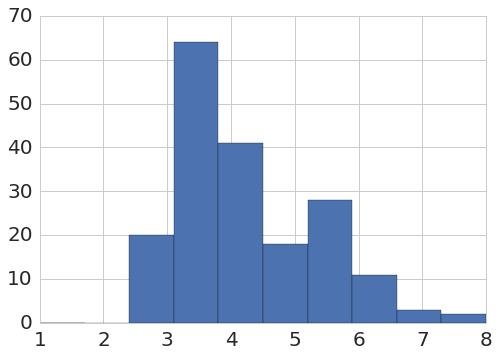

In [58]:
interface_mutation_features_df_final['contact_distance_wt'].hist(range=(1, 8.0))

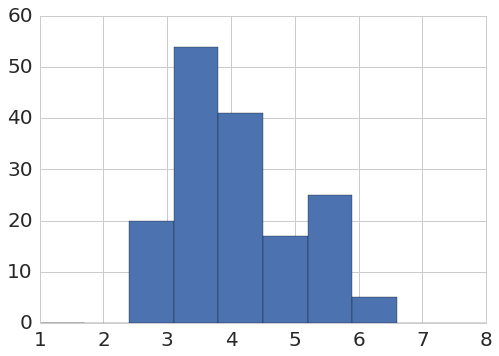

In [59]:
interface_mutation_features_df_final = (
    interface_mutation_features_df_final.drop_duplicates(['pdb_id', 'pdb_mutation']))

interface_mutation_features_df_final = (
    interface_mutation_features_df_final[
        (interface_mutation_features_df_final['contact_distance_wt'] < 6) |
        (interface_mutation_features_df_final['contact_distance_mut'] < 6)
    ]
)
interface_mutation_features_df_final['contact_distance_wt'].hist(range=(1, 8.0))

In [60]:
print2("Number of ELASPIC PDB mutations wddg_exp:", 
       interface_mutation_features_df_final.shape[0])
print2("Number of ELASPIC PDB mutation indexes wddg_exp:",
       len(set(interface_mutation_features_df_final.index)))
print2("Number of unique ELASPIC pdb id / mutations wddg_exp:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])

Number of ELASPIC PDB mutations wddg_exp:                   162
Number of ELASPIC PDB mutation indexes wddg_exp:            162
Number of unique ELASPIC pdb id / mutations wddg_exp:       162


# Save to database

## Core

In [61]:
_header_columns = [
    'pdb_id', 'pdb_chain', 'pdb_mutation', 'mutation', 'mutation_modeller', 'idx',
]

In [62]:
df = (
    core_mutation_features_df_final[
        _header_columns + [c for c in core_mutation_features_df_final.columns if c not in _header_columns]
    ]
)

df.head(2)

,pdb_id,pdb_chain,pdb_mutation,mutation,mutation_modeller,idx,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation_errors,mutation_in_interface,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,ddg_exp,uniprot_id,uniprot_mutation,pfam_id
0,107l,A,A_G44S,G44S,G44S,0,1.0,1.0,1.0,NaN,NaN,A,NaN,NaN,-0.762990,NaN,NaN,NaN,NaN,-1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,,0,-2.001833,"0,0,0,0","0,0,3,18","0,0,0,0","0,0,0,0",3.145,H,H,40.807811,33.615605,"1.05483,-123.522,-45.9071,-191.216,-7.16952,25...","1.73694,-122.908,-45.2756,-190.703,-7.1521,253...",-0.53,None,None,None
1,160l,A,A_A120M,A120M,A120M,0,1.0,1.0,1.0,NaN,NaN,A,NaN,NaN,-1.683732,NaN,NaN,NaN,NaN,-1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,,0,-1.992593,"0,0,0,0","0,0,0,37","0,0,0,0","0,0,0,27",4.550,H,H,16.565388,10.762297,"-16.7144,-128.097,-46.7544,-192.124,-7.50993,2...","-15.5497,-127.91,-46.7544,-190.972,-7.6429,253...",-0.20,None,None,None


In [63]:
DATASET

'protherm_star'

In [64]:
t = db_local.import_df(
    df,
    DATASET + '_core',
)

In [65]:
t.name

'protherm_star_core'

In [66]:
t.create_indexes([
    (['pdb_id', 'pdb_chain', 'pdb_mutation'], True),
    (['uniprot_id', 'uniprot_mutation'], False)
])

In [67]:
t.add_idx_column('_index')

3580

In [68]:
t.compress()

File size before: 2.85 MB
File size after: 1.47 MB
File size savings: 1.47 MB (51.51 %)


## Interface

In [69]:
_if_header_columns = [
    'partner_pdb_chain', 'partner_uniprot_id', 'idxs',
]

In [70]:
df = (
    interface_mutation_features_df_final[
        _header_columns + _if_header_columns + [
            c for c in interface_mutation_features_df_final.columns 
             if c not in (_header_columns + _if_header_columns)
        ]
    ]
)

df.head(2)

,pdb_id,pdb_chain,pdb_mutation,mutation,mutation_modeller,idx,partner_pdb_chain,partner_uniprot_id,idxs,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation_errors,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,ddg_exp,uniprot_id,uniprot_mutation,pfam_id
1182,1hz6,A,A_T25A,T28A,T28A,0,NaN,NaN,"[0, 1]",1.0,1.0,1.0,"9.48767,9.04285,-1.86375,-3.12468,-4.28188,-8....","9.48114,9.06237,-1.34241,-2.99394,-4.07192,-8....",A,2.960603,2.586546,0.327134,344.795,227.805,572.60,0,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,,-1.012759,"0,0,0,4","0,0,0,18","0,0,0,7","0,0,1,17",-5.00,C,C,22.772950,36.685072,"10.617,-90.8421,-30.2506,-135.932,-1.58107,186...","10.9364,-91.3005,-30.6523,-136.067,-1.4978,186...",1.25,Q51912,T134A,PF02246
661,1cdc,A,A_L16V,L13V,L109V,1,NaN,NaN,"[0, 1]",1.0,1.0,1.0,"10.6788,12.4485,-101.173,-53.4043,-16.5584,-91...","10.6669,12.4485,-102.643,-53.4348,-16.5987,-92...",A,2.605022,2.605022,1.277084,2844.425,1972.590,4817.02,1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,,-0.996992,"0,0,0,29","0,0,0,18","0,0,0,37","0,0,0,18",-2.95,E,E,51.239501,58.767676,"26.3147,-116.363,-56.5455,-215.684,-19.4612,29...","24.5747,-116.394,-56.5858,-216.475,-19.4612,29...",2.20,P08921,L38V,PF07686


In [71]:
t = db_local.import_df(
    df,
    DATASET + '_interface',
)

In [72]:
t.name

'protherm_star_interface'

In [73]:
t.create_indexes([
    (['pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation'], True),
    (['uniprot_id', 'partner_uniprot_id', 'uniprot_mutation'], False),
])

In [74]:
t.add_idx_column('_index')

162

In [75]:
t.compress()

File size before: 0.20 MB
File size after: 0.10 MB
File size savings: 0.10 MB (52.62 %)


# Done

In [76]:
datetime.datetime.now()

datetime.datetime(2016, 9, 7, 12, 5, 16, 46379)

In [77]:
os.environ['TMPDIR']

'/tmp/strokach'